# Project: WeRateDogs Twitter Archive Data Wrangling


## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gathering">Data Gathering</a></li>
<ol><li><a href="#gather_archive">Twitter Archive</a></li>
<li><a href="#gather_predictions">Image Predictions Data</a></li>
<li><a href="#gather_json_data">Tweet JSON Data</a></li></ol>
    <ol></ol>
<li><a href="#assess">Assess</a></li>
<ol><li><a href="#assess_tidy">Tidiness Issues</a></li>
<li><a href="#assess_quality">Quality Issues</a></li></ol>
<ol></ol>
<li><a href="#clean">Cleaning</a></li>
<li><a href="#store">Storing</a></li>
<li><a href="#analyse">Analysis</a></li>
</ul>



<a id='intro'></a>
## Introduction

> This is a data wrangling analysis for the dataset of the WeRateDogs Twitter archive, which is a hilarious account to rate the dog's images with funny comments. 

In [1]:
# import the packages used in the investigation
import pandas as pd
import numpy as np
import datetime
import requests
import os
import json
import tweepy as tw
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

<a id='gathering'></a>
## Data Gathering

<a id='gather_archive'></a>
### 1- Twitter Archive

In [2]:
archive_df= pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
archive_df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [4]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

<a id='gather_predictions'></a>
### 2- Image Predictions Data

In [5]:
# assign variables for the url and the tsv file name
url= 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_name= url.split('/')[-1]

# request the data stored in the url 
r= requests.get(url)

# Create the tsv file if it doesn't already exist in the directory 
if not os.path.exists(file_name):
# open the tsv file in the writting mode
    with open(file_name, 'wb') as f:
# write the requested content of the url on the tsv file
        f.write(r.content)

In [6]:
# open the tsv file in a dataframe
image_prediction_df= pd.read_csv('image-predictions.tsv', '\t')

In [7]:
image_prediction_df.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [8]:
image_prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


<a id='gather_json_data'></a>
### 3- Tweet JSON Data

In [9]:
# assign variables for the four Twitter API credential's keys
consumer_key = "******************"
consumer_secret = "************"
access_token = "**************"
access_token_secret = "********"

# authenticate the API access by tweepy using the credentials
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# create an API object using tweepy to allow wrapping the data
api = tw.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [10]:
# use API object to go through the content of a pilot tweet 
pilot_tweet= api.get_status(archive_df.tweet_id[2020], tweet_mode='extended')
tweet_content= pilot_tweet._json
tweet_content

{'created_at': 'Wed Dec 02 16:49:14 +0000 2015',
 'id': 672095186491711488,
 'id_str': '672095186491711488',
 'full_text': "This is Tuco. That's the toast that killed his father. 9/10 https://t.co/ujnWy26RMe",
 'truncated': False,
 'display_text_range': [0, 83],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 672095178996523008,
    'id_str': '672095178996523008',
    'indices': [60, 83],
    'media_url': 'http://pbs.twimg.com/media/CVPDAR9XIAAm8QB.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/CVPDAR9XIAAm8QB.jpg',
    'url': 'https://t.co/ujnWy26RMe',
    'display_url': 'pic.twitter.com/ujnWy26RMe',
    'expanded_url': 'https://twitter.com/dog_rates/status/672095186491711488/photo/1',
    'type': 'photo',
    'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'small': {'w': 510, 'h': 680, 'resize': 'fit'},
     'large': {'w': 768, 'h': 1024, 'resize': 'fit'},
     'medium': {'w': 768, 'h': 1024, 'resize': 

In [11]:
# create a list for the tweet_ids found in the archive dataframe
tweet_ids = archive_df.tweet_id.values
# create an empty error list where the corrupted tweet ids will be placed
tweet_error= []

# create a txt file where the wrapped data will be dumped
if not os.path.exists('tweet_json.txt'):
    with open('tweet_json.txt', 'w') as f:  # open the txt file in the writting mode
        for tweet_id in tweet_ids:    # loop over the tweet_ids list 
            try:    # use API object to wrap the JSON content of each tweet and dump it into the txt file
                s= api.get_status(tweet_id, wait_on_rate_limit=True,  wait_on_rate_limit_notify=True, tweet_mode='extended')
                json.dump(s._json, f)
                f.write('\n')    # separate the data of each tweet with a line
            except Exception as err:
                print('Error for tweet_id {}'.format(str(tweet_id)))
                tweet_error.append(tweet_id)

In [12]:
# create a list for the tweet's JSON data
tweet_list=[]
# open the txt file created in the previous step in the reading mode 
with open('tweet_json.txt', 'rb') as f:
    for line in f:  # loop over the file line by line and pull each tweet as dic. into the empty tweet_list
        tweet= json.loads(line)
        tweet_list.append(tweet)

In [13]:
# convert the tweet_list into a dataframe
api_raw_df= pd.DataFrame(tweet_list)
api_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   created_at                     2331 non-null   object 
 1   id                             2331 non-null   int64  
 2   id_str                         2331 non-null   object 
 3   full_text                      2331 non-null   object 
 4   truncated                      2331 non-null   bool   
 5   display_text_range             2331 non-null   object 
 6   entities                       2331 non-null   object 
 7   extended_entities              2059 non-null   object 
 8   source                         2331 non-null   object 
 9   in_reply_to_status_id          77 non-null     float64
 10  in_reply_to_status_id_str      77 non-null     object 
 11  in_reply_to_user_id            77 non-null     float64
 12  in_reply_to_user_id_str        77 non-null     o

In [14]:
# extract the columns of interest in a working dataframe
api_df=api_raw_df[['id','retweet_count', 'favorite_count']]
api_df.head()

,id,retweet_count,favorite_count
0,892420643555336193,7511,35527
1,892177421306343426,5575,30751
2,891815181378084864,3692,23116
3,891689557279858688,7695,38816
4,891327558926688256,8295,37098


### Output Summary
> At this point, there are three dfs:
><ol>1- archive_df composed of the tweet's text, ratings, and dog classification.</ol>
><ol>2- image_prediction_df includes tweet's image and identification of the dog breed in these images.</ol>
><ol>3- api_df contains the retweet and favorite counts of the tweet_ids.</ol>


<a id='assess'></a>
## Assess

#### - Visual assessment of dfs

In [15]:
archive_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [16]:
image_prediction_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [17]:
api_df

,id,retweet_count,favorite_count
0,892420643555336193,7511,35527
1,892177421306343426,5575,30751
2,891815181378084864,3692,23116
3,891689557279858688,7695,38816
4,891327558926688256,8295,37098
...,...,...,...
2326,666049248165822465,40,96
2327,666044226329800704,126,266
2328,666033412701032449,39,110
2329,666029285002620928,41,120


#### - Check the dfs info

In [18]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [19]:
image_prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [20]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2331 non-null   int64
 1   retweet_count   2331 non-null   int64
 2   favorite_count  2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


#### - Check duplicates

In [21]:
archive_df.duplicated().sum()

0

In [22]:
image_prediction_df.duplicated().sum()

0

In [23]:
api_df.duplicated().sum()

0

In [24]:
all_columns = pd.Series(list(archive_df)+ list(image_prediction_df) + list(api_df))
all_columns[all_columns.duplicated()]

17    tweet_id
dtype: object

In [25]:
archive_df.name.value_counts()

None       745
a           55
Charlie     12
Cooper      11
Lucy        11
          ... 
Lilli        1
Tommy        1
Margo        1
Spencer      1
Oddie        1
Name: name, Length: 957, dtype: int64

<a id='assess_tidy'></a>
### 1- Tidiness Issues

>- name of id column in api_df is not consistent with tweet_id in archive_df and image_prediction_df.
>- four columns for dog stage vriable
>- three separated tables
>- three predictions and confident columns

<a id='assess_quality'></a>
### 2- Quality Issues

>- erroneous dtype of tweet_id, timestamp in archive_df
>- archive_df contains retweets; non-null in_reply_to_status_id, and retweeted_status_id columns
>- archive_df has tweets without images; nulls in expanded_urls columns
>-'name' column contains words that are not names
>- ratings are not calculated in the archive_df
>- erroneous dtype of tweet_id of image_prediction_df
>- erroneous dtype id column of api_df
>- tweet's sources are masked

<a id='clean'></a>
## Cleaning

In [26]:
# copy the dataframes befor cleaning

archive_clean_df = archive_df.copy()
image_clean_df = image_prediction_df.copy()
api_clean_df = api_df.copy()

### Tidiness issues

### Tidiness_Issue #1
#### Define 
Rename the id column of api_df into [tweet_id] to be consistent with archive_df and image_prediction_df

#### Code

In [27]:
# Rename the id column of api_df into [tweet_id] to be consistent with archive_df and image_prediction_df
api_clean_df= api_clean_df.rename(columns= {"id":"tweet_id"})

#### Test

In [28]:
api_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2331 non-null   int64
 1   retweet_count   2331 non-null   int64
 2   favorite_count  2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


### Tidiness_Issue #2
#### Define 
Combine the four columns doggo,floofer,pupper,puppo of archive_df into dog_stage column

#### Code

In [29]:
# Replace None values in the four columns doggo,floofer,pupper,puppo into empty space
stages = ['doggo','pupper', 'floofer', 'puppo' ]
for column in stages:
        archive_clean_df[column] = archive_clean_df[column].replace('None', '')

In [30]:
# Combine the strings in the four columns doggo,floofer,pupper,puppo in a new dog_stage column using cat function
archive_clean_df['dog_stage'] = archive_clean_df.doggo.str.cat(archive_clean_df.floofer).str.cat(archive_clean_df.pupper).str.cat(archive_clean_df.puppo)

In [31]:
# Drop the four columns doggo,floofer,pupper,puppo
archive_clean_df= archive_clean_df.drop(stages, axis= 1)

In [32]:
# Fill the empty records with NaN
archive_clean_df['dog_stage']= archive_clean_df['dog_stage'].replace('', np.nan)

#### Test

In [33]:
archive_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  dog_stage                   380 n

### Tidiness_Issue #3
#### Define 
Merge the archive_df and api_df on tweet_id using merge function

#### Code

In [34]:
# Merge the archive_df and api_df on tweet_id using merge function
tweets_df = pd.merge(archive_clean_df, api_clean_df, on='tweet_id', how= 'inner')

#### Test

In [35]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2331 entries, 0 to 2330
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2331 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2331 non-null   object 
 4   source                      2331 non-null   object 
 5   text                        2331 non-null   object 
 6   retweeted_status_id         163 non-null    float64
 7   retweeted_status_user_id    163 non-null    float64
 8   retweeted_status_timestamp  163 non-null    object 
 9   expanded_urls               2272 non-null   object 
 10  rating_numerator            2331 non-null   int64  
 11  rating_denominator          2331 non-null   int64  
 12  name                        2331 non-null   object 
 13  dog_stage                   375 n

### Tidiness_Issue #4
#### Define 
Combine the predictions columns (p1, p2, p3, p1_conf, p2_conf, p3_conf) into one prediction column & one confidence column

#### Code

In [36]:
prediction = []
prediction_conf= []

def predictions(row):
    if row['p1_dog']:
        prediction.append(row['p1'])
        prediction_conf.append(row['p1_conf'])
    elif row['p2_dog']:
        prediction.append(row['p2'])
        prediction_conf.append(row['p2_conf'])
    elif row['p3_dog']:
        prediction.append(row['p3'])
        prediction_conf.append(row['p3_conf'])
    else:
        prediction.append('Unidentifiable')
        prediction_conf.append(0)

image_clean_df.apply(predictions, axis = 1)

image_clean_df['prediction'] = prediction
image_clean_df['confidence'] = prediction_conf

In [37]:
# drop the untidy columns
image_clean_df.drop(['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog',], axis=1, inplace=True)

#### Test

In [38]:
image_clean_df.head()

,tweet_id,jpg_url,img_num,prediction,confidence
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311


### Quality issues

### Quality_Issue #1
#### Define 
Convert dtype of tweet_id column into string in all dataframs using astype()

#### Code

In [39]:
tweets_df['tweet_id']= tweets_df['tweet_id'].astype('str')

In [40]:
image_clean_df['tweet_id']= image_clean_df['tweet_id'].astype('str')

#### Test

In [41]:
tweets_df['tweet_id'].dtype

dtype('O')

In [42]:
image_clean_df['tweet_id'].dtype

dtype('O')

### Quality_Issue #2
#### Define 
Convert dtype of timestamp column from string to datetime

#### Code

In [43]:
# Convert dtype of timestamp column from string to datetime
tweets_df['timestamp']= pd.to_datetime(tweets_df['timestamp'])

#### Test

In [44]:
tweets_df['timestamp'].dtype

datetime64[ns, UTC]

### Quality_Issue #3
#### Define 
Drop all retweets which are the records with values for in_reply_to_status_id and retweeted_status_id

#### Code

In [45]:
# Remove retweets from the tweets_df
tweets_df = tweets_df[(tweets_df.in_reply_to_status_id.isna() == True)  & (tweets_df.retweeted_status_id.isna() == True)]

#### Test

In [46]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2090 entries, 0 to 2330
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2090 non-null   object             
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   2090 non-null   datetime64[ns, UTC]
 4   source                      2090 non-null   object             
 5   text                        2090 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2087 non-null   object             
 10  rating_numerator            2090 non-null   int64           

### Quality_Issue #4
#### Define 
Drop the missing values in the expanded_urls column as they have no images

#### Code

In [47]:
tweets_df = tweets_df[tweets_df['expanded_urls'].notna()]

#### Test

In [48]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2087 entries, 0 to 2330
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2087 non-null   object             
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   2087 non-null   datetime64[ns, UTC]
 4   source                      2087 non-null   object             
 5   text                        2087 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2087 non-null   object             
 10  rating_numerator            2087 non-null   int64           

### Quality_Issue #5
#### Define 
Drop all unnecessary columns 

#### Code

In [49]:
# Drop all retweet columns from archive_df
unnecessary_columns=['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp', 'expanded_urls']
tweets_df= tweets_df.drop(unnecessary_columns, axis = 1)

#### Test

In [50]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2087 entries, 0 to 2330
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2087 non-null   object             
 1   timestamp           2087 non-null   datetime64[ns, UTC]
 2   source              2087 non-null   object             
 3   text                2087 non-null   object             
 4   rating_numerator    2087 non-null   int64              
 5   rating_denominator  2087 non-null   int64              
 6   name                2087 non-null   object             
 7   dog_stage           334 non-null    object             
 8   retweet_count       2087 non-null   int64              
 9   favorite_count      2087 non-null   int64              
dtypes: datetime64[ns, UTC](1), int64(4), object(5)
memory usage: 179.4+ KB


### Quality_Issue #6
#### Define 
Replace the invalid values in the name column with Null

#### Code

In [51]:
invalid_name = ['a','the','an']
for name in invalid_name:
        tweets_df.name.replace(name, 'None' , inplace=True)

#### Test

In [52]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2087 entries, 0 to 2330
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2087 non-null   object             
 1   timestamp           2087 non-null   datetime64[ns, UTC]
 2   source              2087 non-null   object             
 3   text                2087 non-null   object             
 4   rating_numerator    2087 non-null   int64              
 5   rating_denominator  2087 non-null   int64              
 6   name                2087 non-null   object             
 7   dog_stage           334 non-null    object             
 8   retweet_count       2087 non-null   int64              
 9   favorite_count      2087 non-null   int64              
dtypes: datetime64[ns, UTC](1), int64(4), object(5)
memory usage: 179.4+ KB


### Quality_Issue #7
#### Define 
Extract the source of the tweets from the source column using 're' package

#### Code

In [53]:
tweets_df['source'] = tweets_df['source'].apply(lambda x: re.findall(r'>(.*)<', x)[0])

#### Test

In [54]:
tweets_df['source'].value_counts()

Twitter for iPhone     1956
Vine - Make a Scene      91
Twitter Web Client       30
TweetDeck                10
Name: source, dtype: int64

### Quality_Issue #8
#### Define 
Calculate the ratings values of the tweets

#### Code

In [55]:
# Calculate the ratings value using denominator as 10
tweets_df['ratings']= tweets_df['rating_numerator']/10

In [56]:
# Drop the unrequired ratings_numerator and denominator columns
tweets_df.drop(['rating_numerator', 'rating_denominator'], axis=1, inplace=True)

#### Test

In [57]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2087 entries, 0 to 2330
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   tweet_id        2087 non-null   object             
 1   timestamp       2087 non-null   datetime64[ns, UTC]
 2   source          2087 non-null   object             
 3   text            2087 non-null   object             
 4   name            2087 non-null   object             
 5   dog_stage       334 non-null    object             
 6   retweet_count   2087 non-null   int64              
 7   favorite_count  2087 non-null   int64              
 8   ratings         2087 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(5)
memory usage: 163.0+ KB


<a id='store'></a>
## Storing

In [58]:
master_df = pd.merge(tweets_df, image_clean_df, on='tweet_id')

In [59]:
# store the dataframe into csv file
master_df.to_csv('twitter_archive_master.csv', index=False, encoding = 'utf-8')

<a id='analyse'></a>
## Analysis

### Exploratory Analysis

In [60]:
master_df.describe()

,retweet_count,favorite_count,ratings,img_num,confidence
count,1964.000000,1964.000000,1964.000000,1964.000000,1964.000000
mean,2415.885947,8174.476578,1.222301,1.202138,0.465133
std,4316.039261,12020.741698,4.170816,0.559615,0.339506
min,11.000000,70.000000,0.000000,1.000000,0.000000
25%,539.750000,1755.500000,1.000000,1.000000,0.140339
50%,1169.000000,3691.000000,1.100000,1.000000,0.459560
75%,2763.250000,10193.500000,1.200000,1.000000,0.776453
max,75938.000000,153276.000000,177.600000,4.000000,0.999956


### What are the top ten liked dog breeds?!

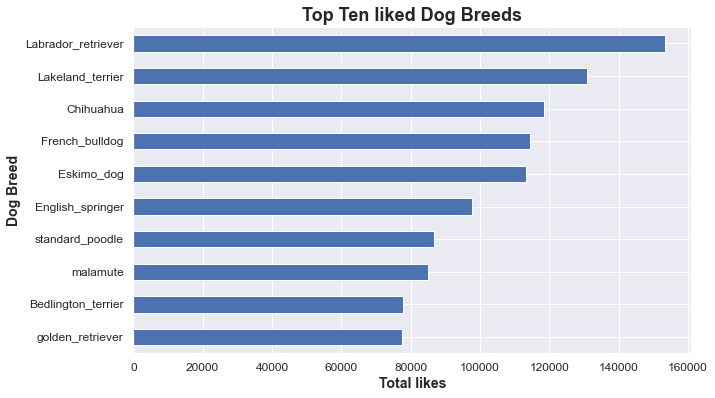

In [61]:
# sort the data by favorite_count to find the top ten favorite records
master_df= master_df.sort_values(by= 'favorite_count', ascending= False)
top_ten_liked_breeds= master_df.head(10)
bar= top_ten_liked_breeds.groupby('prediction').favorite_count.sum().sort_values(ascending=True)
bar.plot(kind= 'barh', fontsize= 12, figsize= (10,6))
plt.xlabel('Total likes', fontsize= 14, weight= 'bold')
plt.ylabel('Dog Breed', fontsize= 14, weight= 'bold')
plt.title('Top Ten liked Dog Breeds', fontsize=(18), weight= 'bold')
plt.show();

#### Observations
> Labrador retriever breed is the most liked breed of dogs followed by Lakeland terrier breed

### Is there any correlation between the retweet and like counts?!

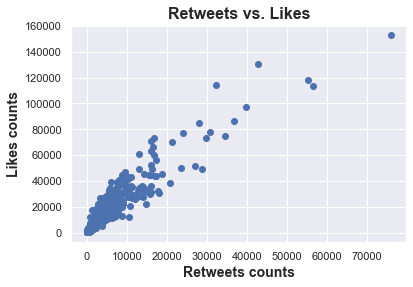

In [62]:
# Plot the correlation between the retweet and like counts
plt.scatter(x=master_df["retweet_count"], y=master_df["favorite_count"])
plt.title("Retweets vs. Likes",fontsize=16, weight='bold')
plt.xlabel("Retweets counts", fontsize=14, weight='bold')
plt.ylabel("Likes counts", fontsize=14, weight='bold')
plt.show();

#### Observations
> The scatter plot shows a positive association between retweets and likes count

### What time of the day is the highest for retweet and likes?!

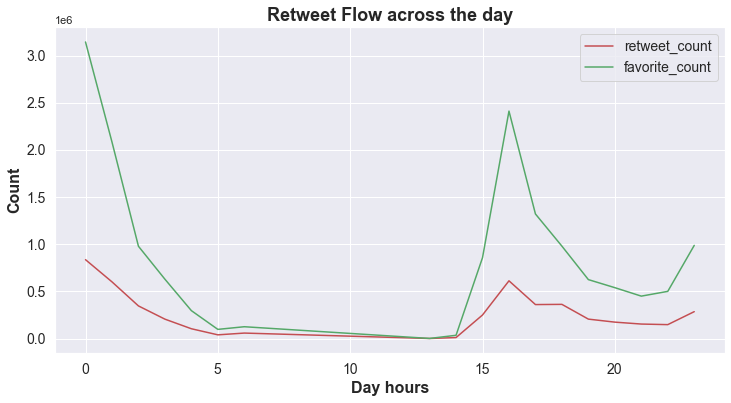

In [63]:
# Extract the hours ofthe day from timestamp column
master_df['hour']= master_df['timestamp'].dt.hour

# Group the retweet_count and favorite_count by hours
day_retweet_flow= master_df.groupby('hour'). retweet_count.sum()
day_favorite_flow= master_df.groupby('hour'). favorite_count.sum()

# Plot a line chart to shows the flow of retweets and favorites across the day
day_retweet_flow.plot(kind= 'line', color= 'r',figsize= (12,6), fontsize= 14)
day_favorite_flow.plot(kind= 'line', color= 'g')
plt.ylabel('Count', fontsize= 16, weight= 'bold')
plt.xlabel('Day hours', fontsize= 16, weight= 'bold')
plt.legend(fontsize= 14)
plt.title('Retweet Flow across the day', fontsize=(18), weight= 'bold');

#### Observations
>- The line plot shows an overall higher favorite count than retweeting
>- However, both increase through night hours and drop in the morning hours till the afternoon time.